# observe data from dimension & voxel_sizes

### 1: Define Analyzer Class

In [1]:
import os
import glob
import numpy as np
import nibabel as nib
from collections import Counter
import pandas as pd

class MedicalImageAnalyzer:
    def __init__(self):
        pass

    def get_file_info(self, file_path):
        """讀取單一檔案的 Dimension 和 Voxel Size"""
        try:
            if not os.path.exists(file_path):
                return None, f"File not found: {file_path}"
            
            img = nib.load(file_path)
            header = img.header
            
            # 取得資訊
            shape = img.shape
            zooms = header.get_zooms()
            
            # 統一格式：只取前三維 (X, Y, Z)
            spatial_shape = tuple(shape[:3])
            spatial_zooms = tuple(np.round(zooms[:3], 2)) # 保留兩位小數
            
            return {
                "path": file_path,
                "shape": spatial_shape,
                "voxel_size": spatial_zooms
            }, None
            
        except Exception as e:
            return None, str(e)

    def scan_directory(self, root_dir):
        """掃描資料夾下所有 .nii.gz 並統計分佈"""
        print(f"Scanning directory: {root_dir} ...")
        
        search_pattern = os.path.join(root_dir, '**', '*.nii.gz')
        files = glob.glob(search_pattern, recursive=True)
        
        print(f"Found {len(files)} NIfTI files. Analyzing headers...")
        
        dim_counter = Counter()
        voxel_counter = Counter()
        bad_files = []
        
        for f in files:
            info, error = self.get_file_info(f)
            if info:
                dim_counter[info['shape']] += 1
                voxel_counter[info['voxel_size']] += 1
            else:
                bad_files.append(f)
                
        return {
            "total_files": len(files),
            "valid_files": len(files) - len(bad_files),
            "dimensions": dim_counter,
            "voxel_sizes": voxel_counter,
            "bad_files": bad_files
        }

    def print_report(self, stats, title="Dataset Report"):
        """格式化輸出報告"""
        print("\n" + "="*60)
        print(f"      {title}      ")
        print("="*60)
        print(f"Total Files Scanned: {stats['total_files']}")
        print(f"Valid Files: {stats['valid_files']}")
        if stats['bad_files']:
            print(f"Failed to load: {len(stats['bad_files'])} files")
        
        # --- 1. Dimension Report ---
        print("\n[1] Dimension Distribution (Matrix Size)")
        print(f"{'Shape (H, W, D)':<30} | {'Count':<10} | {'Percentage'}")
        print("-" * 65)
        
        # 排序：數量多 -> 少
        for shape, count in stats['dimensions'].most_common():
            percentage = (count / stats['valid_files']) * 100
            print(f"{str(shape):<30} | {count:<10} | {percentage:.1f}%")

        # --- 2. Voxel Size Report ---
        print("\n[2] Voxel Size Distribution (Resolution mm)")
        print(f"{'Size (X, Y, Z)':<30} | {'Count':<10} | {'Percentage'}")
        print("-" * 65)
        
        for v_size, count in stats['voxel_sizes'].most_common():
            percentage = (count / stats['valid_files']) * 100
            print(f"{str(v_size):<30} | {count:<10} | {percentage:.1f}%")
        print("-" * 65 + "\n")

# 初始化工具
analyzer = MedicalImageAnalyzer()

### 2: Analyze Single File

Target: /home/n26141826/114-1_TAICA_cv_Final_Project/data_fixed/3D_dataset/train/image/424_full_HV001_1_FATFRACTION.nii.gz
Aspect Ratio: 4.00


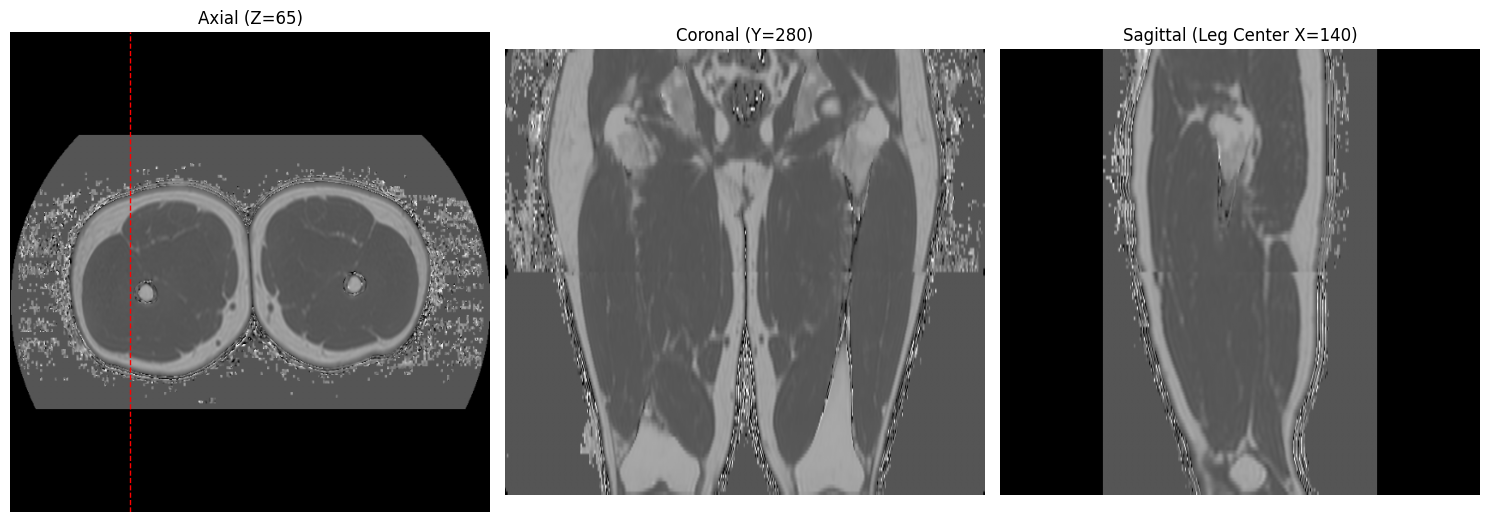

In [2]:
import matplotlib.pyplot as plt
import os
import glob
import nibabel as nib
import numpy as np

# --- 設定路徑 ---
example_file = "/home/n26141826/114-1_TAICA_cv_Final_Project/data_fixed/3D_dataset/train/image/424_full_HV001_1_FATFRACTION.nii.gz"

if not os.path.exists(example_file):
    search = glob.glob("/home/n26141826/114-1_TAICA_cv_Final_Project/data_fixed/**/*.nii.gz", recursive=True)
    example_file = search[0] if search else None

if example_file:
    print(f"Target: {example_file}")
    img = nib.load(example_file)
    data = img.get_fdata()
    data = np.nan_to_num(data)
    
    # 取得 Voxel Size 與 Aspect Ratio
    dx, dy, dz = img.header.get_zooms()[:3]
    aspect_ratio = dz / dy
    print(f"Aspect Ratio: {aspect_ratio:.2f}")

    # === [關鍵修改] 調整切片位置 ===
    # 原始中心點 (會切到兩腿之間)
    x_center = data.shape[0] // 2
    y_center = data.shape[1] // 2
    z_center = data.shape[2] // 2
    
    # 修正：往左邊移動 1/4 的寬度，鎖定「左大腿」中心
    # 或是用 3 * x_center // 2 鎖定右大腿
    x_leg = x_center // 2 

    # 建立畫布
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))

    # 1. Axial (Z-plane): 顯示切片位置輔助線
    axes[0].imshow(data[:, :, z_center].T, cmap='gray', origin='lower', aspect=dy/dx)
    axes[0].set_title(f"Axial (Z={z_center})")
    # 畫出我們 Sagittal 切在哪裡 (紅色虛線)
    axes[0].axvline(x=x_leg, color='red', linestyle='--', linewidth=1)
    axes[0].axis('off')

    # 2. Coronal (Y-plane)
    axes[1].imshow(data[:, y_center, :].T, cmap='gray', origin='lower', aspect=aspect_ratio)
    axes[1].set_title(f"Coronal (Y={y_center})")
    axes[1].axis('off')

    # 3. Sagittal (X-plane) -> 使用修正後的 x_leg
    axes[2].imshow(data[x_leg, :, :].T, cmap='gray', origin='lower', aspect=aspect_ratio)
    axes[2].set_title(f"Sagittal (Leg Center X={x_leg})")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    
else:
    print("File not found.")

### Run original_data & fixed_data

In [3]:
# 這是前置作業，確保我們有 stats_original 和 stats_fixed 可以用
original_data_root = "/home/n26141826/114-1_TAICA_cv_Final_Project/data/3D_dataset/train/image/"
fixed_data_root = "/home/n26141826/114-1_TAICA_cv_Final_Project/data_fixed/3D_dataset/train/image/"

print("Initializing Scan...")
# 假設 analyzer 已經在 Step 1 定義好了
if 'analyzer' not in locals():
    analyzer = MedicalImageAnalyzer()

# 掃描原始資料
print(f"[1/2] Scanning Original Data: {original_data_root}")
stats_original = analyzer.scan_directory(original_data_root)

# 掃描修正後資料
print(f"[2/2] Scanning Fixed Data: {fixed_data_root}")
stats_fixed = analyzer.scan_directory(fixed_data_root)

print("\nScan Complete. Ready for comparison.")

Initializing Scan...
[1/2] Scanning Original Data: /home/n26141826/114-1_TAICA_cv_Final_Project/data/3D_dataset/train/image/
Scanning directory: /home/n26141826/114-1_TAICA_cv_Final_Project/data/3D_dataset/train/image/ ...
Found 522 NIfTI files. Analyzing headers...
[2/2] Scanning Fixed Data: /home/n26141826/114-1_TAICA_cv_Final_Project/data_fixed/3D_dataset/train/image/
Scanning directory: /home/n26141826/114-1_TAICA_cv_Final_Project/data_fixed/3D_dataset/train/image/ ...
Found 439 NIfTI files. Analyzing headers...

Scan Complete. Ready for comparison.


### 3. Analyze Dimensions

In [4]:
import pandas as pd

def compare_dimensions(stats_orig, stats_fixed):
    print("\n" + "="*60)
    print("      [Step 3] Dimension Distribution Comparison      ")
    print("="*60)
    
    # 1. 取得所有出現過的 Shape (聯集)
    all_shapes = set(stats_orig['dimensions'].keys()) | set(stats_fixed['dimensions'].keys())
    
    # 2. 建立比較表資料
    data = []
    for shape in all_shapes:
        count_orig = stats_orig['dimensions'].get(shape, 0)
        count_fixed = stats_fixed['dimensions'].get(shape, 0)
        diff = count_fixed - count_orig
        
        # 簡單標記狀態
        if count_orig > 0 and count_fixed == 0:
            status = "Removed/Merged"
        elif count_orig == 0 and count_fixed > 0:
            status = "New/Created"
        elif count_orig == count_fixed:
            status = "Unchanged"
        else:
            status = "Changed"
            
        data.append({
            "Shape (H, W, D)": str(shape),
            "Original": count_orig,
            "Fixed": count_fixed,
            "Diff": diff,
            "Status": status
        })
    
    # 3. 轉為 DataFrame 並排序
    df = pd.DataFrame(data)
    # 依照 Fixed 數量排序 (主要看現在有的)，再看 Original 數量
    df = df.sort_values(by=["Fixed", "Original"], ascending=False).reset_index(drop=True)
    
    # 4. 顯示
    display(df) # Jupyter Notebook 的優雅顯示方式
    
    # 5. 資工視角總結
    print(f"\n[Summary]")
    print(f"- Total shapes in Original: {len(stats_orig['dimensions'])}")
    print(f"- Total shapes in Fixed:    {len(stats_fixed['dimensions'])}")
    print(f"- New shapes created (Stitched): {len(df[df['Status'] == 'New/Created'])}")

# 執行分析
compare_dimensions(stats_original, stats_fixed)


      [Step 3] Dimension Distribution Comparison      


,"Shape (H, W, D)",Original,Fixed,Diff,Status
0,"(512, 512, 16)",158,158,0,Unchanged
1,"(512, 512, 14)",99,99,0,Unchanged
2,"(560, 560, 130)",0,51,51,New/Created
3,"(512, 512, 15)",45,45,0,Unchanged
4,"(320, 320, 21)",15,15,0,Unchanged
5,"(400, 400, 126)",0,7,7,New/Created
6,"(256, 180, 15)",6,6,0,Unchanged
7,"(512, 512, 12)",6,6,0,Unchanged
8,"(256, 256, 15)",6,6,0,Unchanged
9,"(512, 512, 17)",5,5,0,Unchanged



[Summary]
- Total shapes in Original: 27
- Total shapes in Fixed:    25
- New shapes created (Stitched): 2


### 4. Analyze Voxel Sizes

In [11]:
def compare_voxel_sizes(stats_orig, stats_fixed):
    print("\n" + "="*60)
    print("      [Step 4] Voxel Size Distribution Comparison      ")
    print("="*60)
    
    # 1. 取得所有出現過的 Voxel Size
    all_voxels = set(stats_orig['voxel_sizes'].keys()) | set(stats_fixed['voxel_sizes'].keys())
    
    # 2. 建立比較表資料
    data = []
    for voxel in all_voxels:
        count_orig = stats_orig['voxel_sizes'].get(voxel, 0)
        count_fixed = stats_fixed['voxel_sizes'].get(voxel, 0)
        diff = count_fixed - count_orig
        
        if count_orig > 0 and count_fixed == 0:
            status = "Lost"
        elif count_orig == 0 and count_fixed > 0:
            status = "New"
        elif diff == 0:
            status = "Stable"
        else:
            status = "Decreased (Stitched?)" # 因為拼接會讓檔案數變少
        
        clean_voxel_tuple = tuple(round(float(v), 3) for v in voxel)
        clean_voxel_str = str(clean_voxel_tuple)
        data.append({
            "X": clean_voxel_tuple[0],
            "Y": clean_voxel_tuple[1],
            "Z": clean_voxel_tuple[2],
            "Original": count_orig,
            "Fixed": count_fixed,
            "Diff": diff,
            "Status": status
        })
    
    # 3. 轉為 DataFrame 並排序
    df = pd.DataFrame(data)
    df = df.sort_values(by=["Z","X","Fixed", "Original"], ascending=False).reset_index(drop=True)
    
    # 4. 顯示
    display(df)
    
    # 5. 資工視角總結
    print(f"\n[Summary]")
    # 計算拼接率 (假設減少的檔案都是因為 2合1)
    total_diff = df['Diff'].sum()
    print(f"- Total files reduced: {abs(total_diff)}")
    print(f"- Interpretation: If files decreased but Voxel Size type remains 'Stable' or just reduced count,")
    print(f"  it means stitching used Concatenation without Resampling (which is good for raw data preservation).")

# 執行分析
compare_voxel_sizes(stats_original, stats_fixed)


      [Step 4] Voxel Size Distribution Comparison      


,X,Y,Z,Original,Fixed,Diff,Status
0,0.94,0.94,26.0,16,16,0,Stable
1,0.90,0.90,26.0,10,10,0,Stable
2,0.86,0.86,26.0,11,11,0,Stable
3,0.82,0.82,26.0,6,6,0,Stable
4,0.78,0.78,26.0,8,8,0,Stable
5,0.74,0.74,26.0,16,16,0,Stable
6,0.94,0.94,24.0,19,19,0,Stable
7,0.90,0.90,24.0,8,8,0,Stable
8,0.86,0.86,24.0,7,7,0,Stable
9,0.82,0.82,24.0,27,27,0,Stable



[Summary]
- Total files reduced: 83
- Interpretation: If files decreased but Voxel Size type remains 'Stable' or just reduced count,
  it means stitching used Concatenation without Resampling (which is good for raw data preservation).
